# Time-series Anomaly Detection. GAN(USAD) model with HAI

220517

- [ref1](https://dacon.io/competitions/official/235757/codeshare/3652)
- [ref2](https://github.com/manigalati/usad/blob/master/usad.py)
- [ref3](https://www.youtube.com/watch?v=gCleQ9JxibI&ab_channel=%EA%B3%A0%EB%A0%A4%EB%8C%80%ED%95%99%EA%B5%90%EC%82%B0%EC%97%85%EA%B2%BD%EC%98%81%EA%B3%B5%ED%95%99%EB%B6%80DSBA%EC%97%B0%EA%B5%AC%EC%8B%A4)

# 0_데이터 준비

- 1) 아래 URL에서 데이터를 다운로드
- 2) 235757_HAICon2021_dataset.zip 파일을 colab에 upload, 그런데 너무 오래걸려요! 이번엔 구글 드라이브에 연동해 봅시다

- 3) 구글 드라이브에 다운받은 235757_HAICon2021_dataset.zip 파일을 업로드 후 아래 코드를 실행

- [DATA DOWNLOAD URL](https://dacon.io/competitions/official/235757/data)

In [1]:
# 구글 드라이브 colab과 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# MyDrive 폴더 안에 235757_HAICon2021_dataset.zip 파일이 잘 업로드 되어있나요?
!ls /content/drive/MyDrive/

 0000.zip  '200924_축의금 목록.xlsx'	   'My Drive'
 000.zip    235757_HAICon2021_dataset.zip   YOLOv5_test
 0.zip	   'Colab Notebooks'		   '강아지 그림 사진.zip'


In [3]:
# 그럼 이 코드로 colab으로 가져옵니다. 엄청 빠릅니다.
!cp /content/drive/MyDrive/235757_HAICon2021_dataset.zip .

In [4]:
# data 폴더를 만든 후 그 안에 압축을 풉시다
import os
# 파일이 이미 있으면 pass
if not os.path.exists('data/train'):
    !mkdir ./data
    !mv 235757_HAICon2021_dataset.zip ./data/
    %cd ./data
    !unzip ./235757_HAICon2021_dataset.zip
    %cd ..


/content/data
Archive:  ./235757_HAICon2021_dataset.zip
  inflating: eTaPR-21.8.2-py3-none-any.whl  
  inflating: sample_submission.csv   
   creating: test/
  inflating: test/test1.csv          
  inflating: test/test2.csv          
  inflating: test/test3.csv          
   creating: train/
  inflating: train/train1.csv        
  inflating: train/train2.csv        
  inflating: train/train3.csv        
  inflating: train/train4.csv        
  inflating: train/train5.csv        
  inflating: train/train6.csv        
   creating: validation/
  inflating: validation/validation.csv  
/content


In [5]:
## setup
!python -m pip install data/eTaPR-21.8.2-py3-none-any.whl  # TaPR은 평가 metric 설치
!pip install watermark 
%reload_ext watermark
%watermark -v -p dateutil,numpy,matplotlib,pandas,torch,tqdm,TaPR_pkg,cv2

Processing ./data/eTaPR-21.8.2-py3-none-any.whl
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.
Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

dateutil  : 2.8.2
numpy     : 1.21.6
matplotlib: 3.2.2
pandas    : 1.3.5
torch     : 1.11.0+cu113
tqdm      : 4.64.0
TaPR_pkg  : unknown
cv2       : 4.1.2



# 본격적으로 시작!

In [6]:
## load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

In [7]:
# 
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from tqdm import tqdm

# 1_Prepare data

In [8]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [9]:
TRAIN_DATASET = sorted([x for x in Path("./data/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./data/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("./data/validation/").glob("*.csv")])

In [10]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)

## Train dataset에 csv가 여러개므로 각각 쪼개서 만든다??
TRAIN_DF_RAW_01 = dataframe_from_csv(TRAIN_DATASET[0])
TRAIN_DF_RAW_01.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_02 = dataframe_from_csv(TRAIN_DATASET[1])
TRAIN_DF_RAW_02.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_03 = dataframe_from_csv(TRAIN_DATASET[2])
TRAIN_DF_RAW_03.reset_index(drop=True,inplace=True)

# TRAIN_DF_RAW_04 = dataframe_from_csv(TRAIN_DATASET[3])
# TRAIN_DF_RAW_04.reset_index(drop=True,inplace=True)

# TRAIN_DF_RAW_05 = dataframe_from_csv(TRAIN_DATASET[4])
# TRAIN_DF_RAW_05.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_06 = dataframe_from_csv(TRAIN_DATASET[5])
TRAIN_DF_RAW_06.reset_index(drop=True,inplace=True)

print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


아래 두 목록에는 중복된 장치들이 있으니 이 점 유의하시면 좋을 것 같습니다.

변화가 없는 장치 목록
- C22, C52, C63, C82, C85, C55, C36, C26, C49, C38, C39, C29, C18, C19, C09

범주형 데이터 형태인 장치 목록
- C02, C07, C08, C09, C10, C17, C18, C19, C22, C26, C29, C34, C35, C36, C38, C39, C46, C48, C49, C52, C55, C58, C61, C63, C64, C69, C79, C82, C85

예측의 Loss 값이 튀는 경우를 없애주기 위해서 범주형 데이터의 경우 제외시켜주었습니다.

하지만 유의미한 결과를 보지는 못했던 것 같습니다.

In [11]:
TIMESTAMP_FIELD = "timestamp"
DROP_FIELD = ["C02", "C07", "C08", "C09", "C10", "C17", "C18", "C19", "C22", "C26", "C29", "C34", "C35", "C36", "C38", "C39", "C46", "C48", "C49", "C52", "C55", "C58", "C61", "C63", "C64", "C69", "C79", "C82", "C85"]
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW_01.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET = VALID_COLUMNS_IN_TRAIN_DATASET.drop(DROP_FIELD)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C03', 'C04', 'C05', 'C06', 'C11', 'C12', 'C13', 'C14', 'C15',
       'C16', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31',
       'C32', 'C33', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C47',
       'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C59', 'C60', 'C62', 'C65',
       'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76',
       'C77', 'C78', 'C80', 'C81', 'C83', 'C84', 'C86'],
      dtype='object')

In [12]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [13]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [14]:
TRAIN_DF_01 = normalize(TRAIN_DF_RAW_01[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_02 = normalize(TRAIN_DF_RAW_02[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_03 = normalize(TRAIN_DF_RAW_03[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
# TRAIN_DF_04 = normalize(TRAIN_DF_RAW_04[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
# TRAIN_DF_05 = normalize(TRAIN_DF_RAW_05[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_06 = normalize(TRAIN_DF_RAW_06[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [15]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [16]:
##
# [N, window_size, 변수개수], [93589, 12, 57]
# [    0,     1,     2, ...,     9,    10,    11],
# [    1,     2,     3, ...,    10,    11,    12],
window_size=12

windows_normal_01 = TRAIN_DF_01.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_01.shape[0]-window_size)[:, None]]
windows_normal_02 = TRAIN_DF_02.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_02.shape[0]-window_size)[:, None]]
windows_normal_03 = TRAIN_DF_03.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_03.shape[0]-window_size)[:, None]]
# windows_normal_04 = TRAIN_DF_04.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_04.shape[0]-window_size)[:, None]]
# windows_normal_05 = TRAIN_DF_05.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_05.shape[0]-window_size)[:, None]]
windows_normal_06 = TRAIN_DF_06.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_06.shape[0]-window_size)[:, None]]

print(windows_normal_01.shape)

(93589, 12, 57)


In [17]:
import torch.utils.data as data_utils

BATCH_SIZE =  5000
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal_01.shape[1]*windows_normal_01.shape[2]  # 684, window_size x 변수개수, 12x57
z_size=windows_normal_01.shape[1]*hidden_size  # 1200, window_size x hiddenvectorsize, 12x100

# [N, 12, 57] -> [N, 684]
train_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_01).float().view(([windows_normal_01.shape[0], w_size])))
train_loader_02 = data_utils.TensorDataset(torch.from_numpy(windows_normal_02).float().view(([windows_normal_02.shape[0], w_size])))
train_loader_03 = data_utils.TensorDataset(torch.from_numpy(windows_normal_03).float().view(([windows_normal_03.shape[0], w_size])))
# train_loader_04 = data_utils.TensorDataset(torch.from_numpy(windows_normal_04).float().view(([windows_normal_04.shape[0], w_size])))
# train_loader_05 = data_utils.TensorDataset(torch.from_numpy(windows_normal_05).float().view(([windows_normal_05.shape[0], w_size])))

val_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_06).float().view(([windows_normal_06.shape[0],w_size])))

train_loader = torch.utils.data.DataLoader(data_utils.ConcatDataset(
    # [train_loader_01, train_loader_02, train_loader_03, train_loader_04, train_loader_05]
    [train_loader_01, train_loader_02, train_loader_03]    
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_loader_01, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [18]:
## prepare test data
VALIDATION_DF_RAW = dataframe_from_csv(VALIDATION_DATASET[0])
VALIDATION_DF_RAW.reset_index(drop=True,inplace=True)
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

# val dataset: [86388, 12, 57]
val = VALIDATION_DF.values[np.arange(window_size)[None, :] + np.arange(VALIDATION_DF.shape[0]-window_size)[:, None]]

# dataset -> data_loader, [86388, 12, 57] -> [86388, 684]
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(val).float().view(([val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## 정답 label 구하기
validation_labels = [int(label!= 0 ) for label in VALIDATION_DF_RAW["attack"].values]  # [0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 공격은 1

# 2_Prepare model

In [19]:
## model
import torch.nn as nn

device = get_default_device()

class Encoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, int(in_size/2))
        self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
        self.linear3 = nn.Linear(int(in_size/4), latent_size)
        self.relu = nn.ReLU(True)
        
    def forward(self, w):
        out = self.linear1(w)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        z = self.relu(out)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, int(out_size/4))
        self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
        self.linear3 = nn.Linear(int(out_size/2), out_size)
        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.linear1(z)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        w = self.sigmoid(out)
        return w
    
class UsadModel(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
  
    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return loss1,loss2

    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return {'val_loss1': loss1, 'val_loss2': loss2}
        
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            
            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            
            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
            
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [20]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

# 3_Training

In [21]:
%%time
N_EPOCHS=100
history = training(N_EPOCHS, model, train_loader, val_loader)

Epoch [0], val_loss1: 0.0465, val_loss2: 0.0426
Epoch [1], val_loss1: 0.0514, val_loss2: -0.0140
Epoch [2], val_loss1: 0.0430, val_loss2: -0.0141
Epoch [3], val_loss1: 0.0297, val_loss2: -0.0150
Epoch [4], val_loss1: 0.0281, val_loss2: -0.0170
Epoch [5], val_loss1: 0.0275, val_loss2: -0.0183
Epoch [6], val_loss1: 0.0272, val_loss2: -0.0195
Epoch [7], val_loss1: 0.0271, val_loss2: -0.0204
Epoch [8], val_loss1: 0.0284, val_loss2: -0.0222
Epoch [9], val_loss1: 0.0267, val_loss2: -0.0214
Epoch [10], val_loss1: 0.0305, val_loss2: -0.0255
Epoch [11], val_loss1: 0.0921, val_loss2: -0.0776
Epoch [12], val_loss1: 0.1141, val_loss2: -0.1029
Epoch [13], val_loss1: 0.1233, val_loss2: -0.1131
Epoch [14], val_loss1: 0.1255, val_loss2: -0.1159
Epoch [15], val_loss1: 0.1293, val_loss2: -0.1203
Epoch [16], val_loss1: 0.2257, val_loss2: -0.2082
Epoch [17], val_loss1: 0.2960, val_loss2: -0.2659
Epoch [18], val_loss1: 0.2812, val_loss2: -0.2623
Epoch [19], val_loss1: 0.2805, val_loss2: -0.2627
Epoch [20],

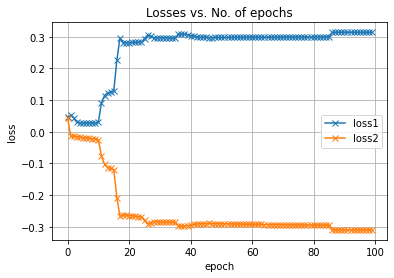

In [22]:
plot_history(history)

In [23]:
## save & reload
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            },
    "./model_usad.pth")

print('save done')

checkpoint = torch.load("./model_usad.pth")
model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

print('load done')

save done
load done


# Test!

In [24]:
## run model to test data
def testing(model, test_loader, alpha=0.5, beta=0.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)  # data to gpu
        w1=model.decoder1(model.encoder(batch))  # encoding and decoding
        w2=model.decoder2(model.encoder(w1))  # encoding and decoding and again encoding and decoding
        
        # get loss
        loss1 = torch.mean((batch-w1)**2, axis=1)
        loss2 = torch.mean((batch-w2)**2, axis=1)
        loss = alpha*loss1 + beta*loss2
        results.append(loss)
    return results  # N개의 [7919]차원 벡터 list

results = testing(model, test_loader)

In [25]:
## 모델이 예측한 prediction값 구하기
# batch화 되있는 데이터를 풀어서 데이터 개수만큼의 label값을 구한다
# 맨 마지막 batch는 데이터가 배치보다 작으니까
# [10, batch_size] -> [batch_sizex10] + [마지막 배치 결과]
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

print(len(validation_labels), len(y_pred))  # window 크기만큼 데이터가 빈다

86400 86388


In [26]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * np.array(peak) * np.array(0.3))
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

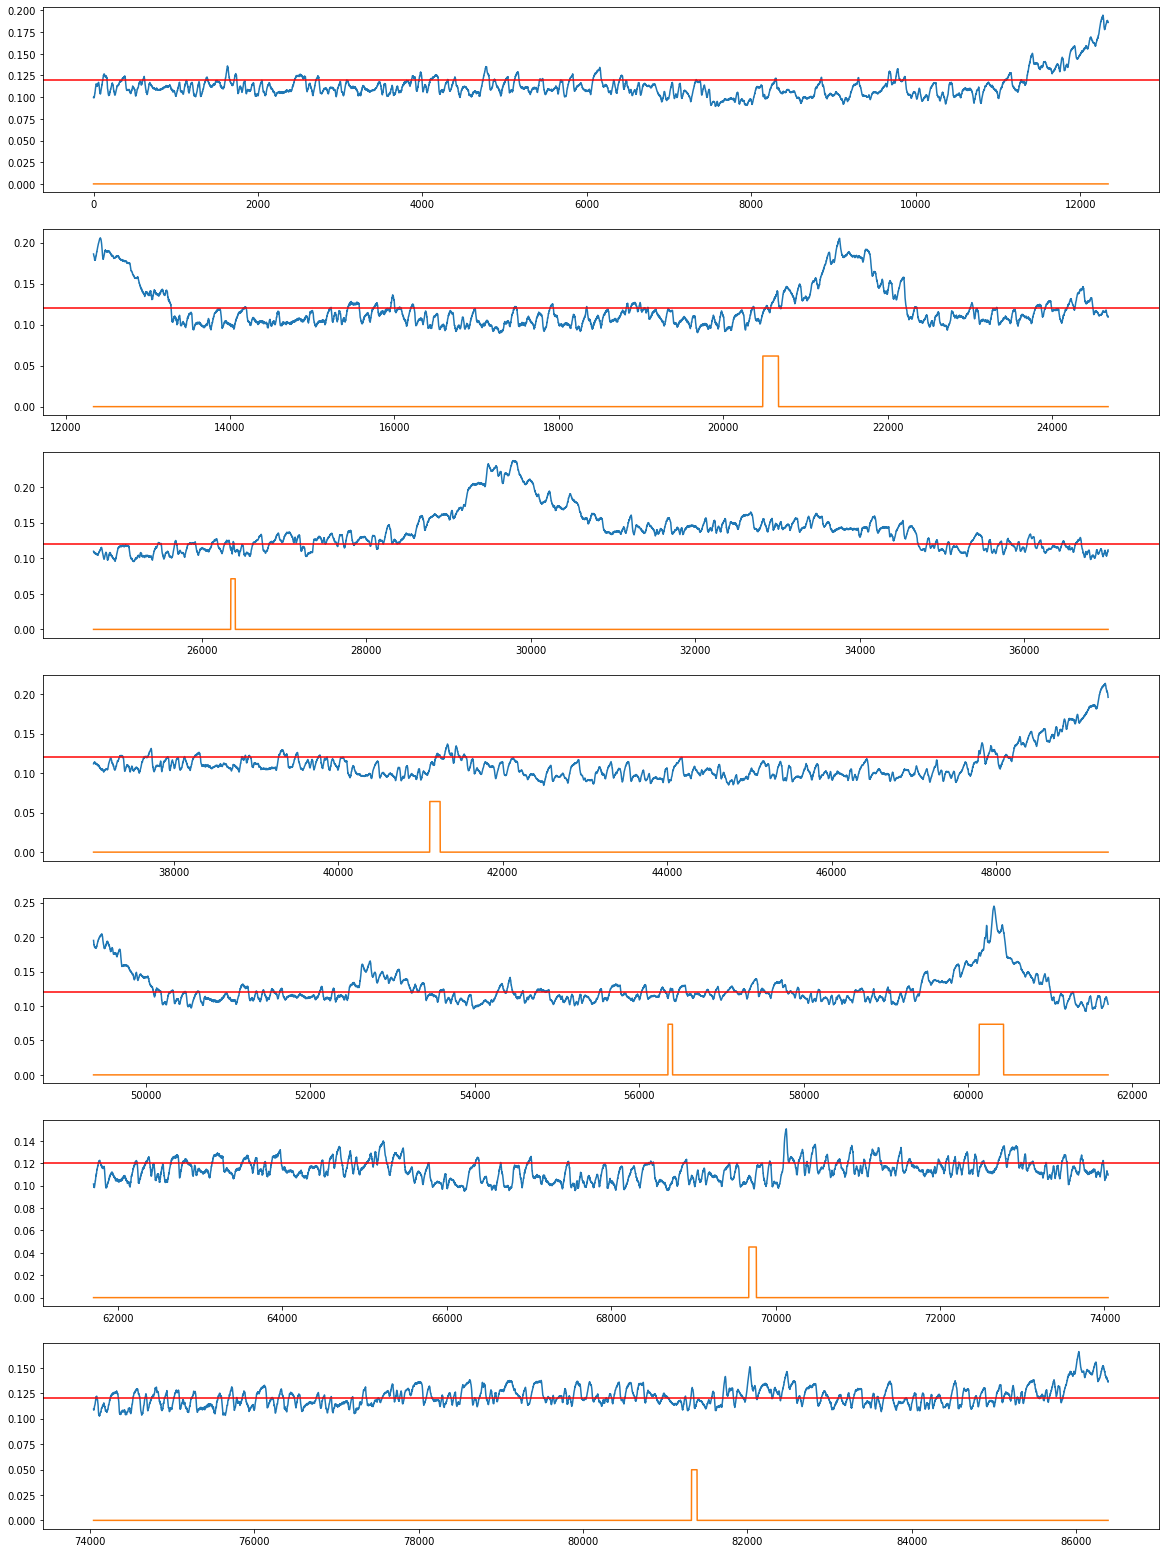

In [52]:
THRESHOLD=0.12
check_graph(y_pred, validation_labels, piece=7, THRESHOLD=THRESHOLD)

In [53]:
# prediction 값이 threshold보다 크면(실제값과 예측값의 차이가 크면) 공격(1)로 체크한다
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

prediction_labels = put_labels(y_pred, THRESHOLD)
prediction_labels, prediction_labels.shape

a = np.zeros(window_size)
prediction_labels = np.append(a, prediction_labels, axis=0)

## get test metric

In [54]:
TaPR = etapr.evaluate_haicon(anomalies=validation_labels, predictions=prediction_labels)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.020 (TaP: 0.010, TaR: 0.382)
# of detected anomalies: 5
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f5c3645efd0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f5c3645e850>, <TaPR_pkg.DataManage.Range.Range object at 0x7f5c3645e250>, <TaPR_pkg.DataManage.Range.Range object at 0x7f5c3645e490>, <TaPR_pkg.DataManage.Range.Range object at 0x7f5c364278d0>]
